<h1 style="text-align:center;">Proyek UTS - Classifier non-ANN</h1>
<p style="font-size:1.5em;">Disusun oleh Kelompok Dendeng</p>
<ol>
    <li style="font-size:1.25em;">Alfian Badrul Isnan (1806148643)</li>
    <li style="font-size:1.25em;">Farid Muhammad Rahman (1806148662)</li>
    <li style="font-size:1.25em;">Sherly (1806148832)</li>
    <li style="color:green;font-size:1.25em;">Alvin Audinata (1806200204)</li>
</ol>

<h2>Pendahuluan</h2>
<p>Dalam project kelompok, saya mendapat bagian untuk mengimplementasikan algoritma Naive Bayes pada dataset yang kami pilih sendiri sesuai ketentuan yang diberikan. Dataset yang kami gunakan adalah Letter Recognition yang bersumber dari UCI Machine Learning Repository, yang dapat diakses <a href="http://archive.ics.uci.edu/ml/datasets/Letter+Recognition">di sini</a>. Dataset tersebut telah terlebih dahulu di-<i>pre-process</i> berupa penyamaan data antar setiap kelasnya, pengacakan (<i>randomization</i>) data pada setiap kelasnya, serta pembagian dataset menjadi dataset training dan dataset training dengan perbandingan yang sama seperti yang dipersyaratkan, yang dilakukan dalam notebook yang terpisah dan ditempatkan dalam dua file <abbr title="Comma-Separated Values">CSV</abbr> yang berbeda, sehingga dalam notebook ini akan digunakan data training dan data testing yang sudah diproses dan dipecah tersebut.</p>
<p>Sebelum masuk ke dalam pengolahan data, kita perlu mengimpor beberapa library yang dibutuhkan dalam notebook ini. <span style="font-family:'Courier New';">pandas</span> akan digunakan untuk pengolahan Dataframe dan menampilkannya dalam bentuk tabel dan/atau grafik (salah satunya untuk membandingkan recognition rate antara ketiga variasi hyperparameter untuk setiap percobaan). <span style="font-family:'Courier New';">numpy</span> akan digunakan untuk membandingkan antara hasil prediksi dengan yang seharusnya dan menampilkan nilai kebenaran berdasarkan hasil perbandingan tersebut. <span style="font-family:'Courier New';">string</span> akan digunakan untuk keperluan casting variabel ke dalam bentuk String agar dapat ditampilkan. Dalam library <span style="font-family:'Courier New';">math</span> akan digunakan fungsi <span style="font-family:'Courier New';">sqrt()</span> untuk keperluan mencari standar deviasi diberikan nilai variasi. <span style="font-family:'Courier New';">matplotlib.pyplot</span> dipakai untuk memodelkan distribusi Gaussian yang dibentuk dari pembelajaran data training dan digunakan untuk memprediksi data testing. <span style="font-family:'Courier New';">scipy.stats</span> digunakan untuk merepresentasikan <i>mean</i> dan standar deviasi ke dalam distribusi Gaussian yang sesuai. Terakhir, <span style="font-family:'Courier New';">sklearn.naive_bayes</span> menyediakan fungsi utama untuk melakukan klasifikasi menggunakan Naive Bayes, tepatnya Gaussian Naive Bayes, yaitu <span style="font-family:'Courier New';">GaussianNB()</span>.</p>

In [1]:
import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.naive_bayes import GaussianNB

<h2>Definisi fungsi-fungsi pendukung</h2>
<p>Berikutnya, kita akan mendefinisikan serangkaian fungsi yang dapat dipakai berulang kali, dimana setiap fungsi tersebut punya tujuan spesifiknya masing-masing, dengan tujuan mengurangi duplikasi code dalam notebook ini. Pertama, diberikan sebuah Dataframe, fungsi <span style="font-family:'Courier New';">caption()</span> akan juga akan mengembalikan Dataframe tetapi yang sudah diberi label (<i>caption</i>, sesuai namanya) yang diberikan sebagai argumen <span style="font-family:'Courier New';">txt</span> yang menjelaskan Dataframe tersebut.</p>

In [2]:
def caption(df, txt):
    return df.style.set_caption(txt).set_table_styles([dict(selector="caption",
                                                            props=[("text-align", "center"),
                                                                   ("font-size", "150%"),
                                                                   ("font-weight", "bold"),
                                                                   ("color", 'black')])])

<p>Berikutnya, fungsi <span style="font-family:'Courier New';">gaussian_nb()</span> dapat dikatakan sebagai fungsi core (utama) dalam notebook ini yang akan melakukan segala sesuatu terkait dengan algoritma Naive Bayes, meliputi mempelajari data training dengan mempertimbangkan hyperparameter yang disuplai sebagai argumen <span style="font-family:'Courier New';">smoothing</span>, sekaligus memrediksi kelas-kelas dari setiap data testing yang diberikan lalu memandingkan hasilnya dengan kelas-kelas yang seharusnya dari setiap data. Jika hasil prediksi sesuai dengan yang seharusnya, maka isi feature "Correct?" pada baris data tersebut akan berisi "Correct" selebihnya "Incorrect". Kolom hasil prediksi kelas, kelas yang seharusnya, dan feature "Correct" akan disatukan (secara kolom) sebagai <span style="font-family:'Courier New';">res</span>. Semua parameter yang diprediksi pada Gaussian Naive Bayes, meliputi prior probability, <i>mean</i> (<span style="font-family:'Courier New';">theta</span>), dan <i>variance</i> (<span style="font-family:'Courier New';">sigma</span>) beserta salinan seluruh kelas dalam dataset dan proporsi variasi tertinggi yang akan ditambahkan pada setiap variasi, akan dikembalikan bersamaan dengan res sebagai keluaran dari fungsi ini.</p>

In [3]:
def gaussian_nb(X_train, X_test, Y_train, Y_test, smoothing):
    gnb = GaussianNB(var_smoothing=smoothing)
    gnb_learned = gnb.fit(X_train, Y_train)
    Y_pred = gnb_learned.predict(X_test)
    Y_pred = pd.DataFrame(Y_pred, columns=["Prediction"])
    Y_test = Y_test.to_frame().rename(columns={"letter": "Expected"})
    res = pd.concat([Y_pred, Y_test], axis='columns')
    res["Correct?"] = np.where(res["Prediction"] == res["Expected"], "Correct", "Incorrect")
    return res, gnb_learned.classes_, gnb_learned.class_prior_, gnb_learned.epsilon_, gnb_learned.theta_, gnb_learned.sigma_

<p><span style="font-family:'Courier New';">pred_table()</span> akan menerima input <span style="font-family:'Courier New';">res</span> hasil dari <span style="font-family:'Courier New';">gaussian_nb</span> untuk menyempurnakan representasi hasil prediksi pada <span style="font-family:'Courier New';">res</span> sekaligus menghitung <i>recognition rate</i> dari setiap kelas dan menyatukannya dengan tabel dalam <span style="font-family:'Courier New';">res</span> secara kolom. Terkait dengan penyempurnaan representasi, <span style="font-family:'Courier New';">pred_table()</span> akan menamai ulang kolom kelas yang seharusnya dari "letter" menjadi "Expected". Sementara itu, <i>recognition rate</i> untuk setiap kelas ditentukan dengan mencari persentase jumlah data kelas tersebut yang diprediksi dengan benar terhadap jumlah seluruh data dalam kelas tersebut. Sebagai hasilnya, <span style="font-family:'Courier New';">pred_table()</span> akan mengembalikan salinan <span style="font-family:'Courier New';">res</span> yang telah "dipercantik" yang sudah dilengkapi dengan <i>recognition rate</i>.</p>

In [4]:
def pred_table(res):
    total_rows = len(res)
    columns = ["Class", "Correct", "Total", "Recognition rate (%)"]
    pred_table = pd.DataFrame(columns=columns)
    for alphabet in alphabets:
        class_correct = res[(res["Expected"] == alphabet) & (res["Correct?"] == "Correct")]
        class_row_correct = len(class_correct)
        class_total = res[(res["Expected"] == alphabet)]
        class_row_total = len(class_total)
        class_correct_percent = round(class_row_correct * 100 / class_row_total, 2)
        entry = pd.DataFrame([[alphabet, class_row_correct, class_row_total, class_correct_percent]], columns=columns)
        pred_table = pred_table.append(entry)
    return pred_table.reset_index(drop=True)

<p><span style="font-family:'Courier New';">recognition_compare_graph()</span> berfungsi untuk memvisualisasikan <i>recognition rate</i> Gaussian Naive Bayes terhadap dataset ini untuk tiga variasi hyperparameter yang berbeda (detailnya akan dijelaskan kemudian) sebagai parameter <span style="font-family:'Courier New';">pred_table_1</span>, <span style="font-family:'Courier New';">pred_table_2</span>, dan <span style="font-family:'Courier New';">pred_table_3</span>, dalam bentuk grafik batang dimana untuk setiap kelas, batang dari ketiga variasi hyperparameter akan dikelompokkan (<i>grouped</i>). Setiap batang kemudian akan dilabelkan dengan label yang sesuai, begitu juga dengan kedua sumbunya dan judul grafik tersebut. Sebagai keluarannya, <span style="font-family:'Courier New';">recognition_compare_graph()</span> akan mengembalikan grafik batang yang sudah dibuat sehingga dapat digunakan kemudian.</p>

In [5]:
def recognition_compare_graph(pred_table_1, pred_table_2, pred_table_3):
    percent_1 = pred_table_1["Recognition rate (%)"]
    percent_1 = percent_1.rename("VarSmooth = 1e-9")
    percent_2 = pred_table_2["Recognition rate (%)"]
    percent_2 = percent_2.rename("VarSmooth = 1e-5")
    percent_3 = pred_table_3["Recognition rate (%)"]
    percent_3 = percent_3.rename("VarSmooth = 0.1")
    df_alphabets = pd.DataFrame(alphabets)
    percent = pd.concat([df_alphabets, percent_1, percent_2, percent_3], axis="columns")
    plot = percent.plot.bar(figsize=(18, 7), ylim=[0, 100])
    plot.set(xlabel="Class", xticklabels=alphabets, ylabel="Recognition rate (%)")
    return plot

<p><span style="font-family:'Courier New';">gaussian_plot_j()</span> berfungsi untuk merepresentasikan distribusi Gaussian sebagai hasil pembelajaran data training yang nantinya akan digunakan untuk memprediksi kelas-kelas dari data testing, dimana representasi ini dibatasi untuk kelas "J" dan untuk sembilan <i>feature</i> bebas saja (dari "x_box" hingga "y2bar" secara berturut-turut), dengan maksud agar grafik-grafik yang dibuat dapat menunjukkan pengaruh hyperparameter <i>variance smoothing</i> terhadap <i>mean</i> dan standar deviasi distribusi yang dihasilkan dan ukuran grafik-grafik tersebut dapat dibuat <i>compact</i> tanpa menghilangkan esensinya. Pertama-tama, grafik akan dipecah ke dalam sembilan subplot dimana masing-masing subplot menggambarkan distribusi salah satu dari kesembilan feature yang dipertimbangkan untuk kelas "J". Batas-batas horizontal untuk kesembilan subplot tersebut kemudian diatur masing-masing pada nilai <i>mean</i> dikurang tiga kali standar deviasi terkecil dan jumlah <i>mean</i> dan tiga kali standar deviasi terbesar untuk setiap variasi hyperparameter dan untuk setiap <i>feature</i> dari kesembilan <i>feature</i> yang dipertimbangkan, dengan maksud mencegah adanya bagian dari seluruh distribusi Gaussian yang tergambar "keluar" dari grafik sehingga tidak terlihat, membuat representasi menjadi kurang baik. Kemudian, masing-masing distribusi dari ketiga hyperparameter untuk setiap <i>feature</i> akan digambarkan pada subplot yang sesuai. Tak lupa, untuk setiap subplot, keterangan kedua sumbu, legenda yang memetakan warna garis dengan variasi hyperparameter, serta judul masing-masing subplot akan disertakan. Terakhir, fungsi ini akan mengembalikan kesembilan subplot tersebut dalam kedua grafik, yang kemudian dapat ditampilkan dari sel pemanggilnya.</p>

In [6]:
def gaussian_plot_j(var_1, var_2, var_3, mean_1, mean_2, mean_3):
    var_j = [var_1[9, :9], var_2[9, :9], var_3[9, :9]]
    std_j = [[math.sqrt(var_val) for var_val in var_jx] for var_jx in var_j]
    std_thrice_j = [[3*std for std in std_jx] for std_jx in std_j]
    mean_j = [list(mean_1[9, :9]), list(mean_2[9, :9]), list(mean_3[9, :9])]
    fig_min = min(min([(mean - std_thrice) for (mean, std_thrice) in zip(mean_jx, std_thrice_jx)] for (mean_jx, std_thrice_jx) in zip(mean_j, std_thrice_j)))
    fig_max = max(max([(mean + std_thrice) for (mean, std_thrice) in zip(mean_jx, std_thrice_jx)] for (mean_jx, std_thrice_jx) in zip(mean_j, std_thrice_j)))
    plt.rcParams["figure.figsize"] = [15,12]
    plt.rc("figure.subplot", wspace=0.3, hspace=0.4)
    _, ax = plt.subplots(3, 3)
    interval = np.linspace(fig_min, fig_max)
    for i in range(0, 3):
        for j in range (0, 3):
            plot_1, = ax[i, j].plot(interval, stats.norm.pdf(interval, mean_j[0][i*3+j], std_j[0][i*3+j]))
            plot_2, = ax[i, j].plot(interval, stats.norm.pdf(interval, mean_j[1][i*3+j], std_j[1][i*3+j]))
            plot_3, = ax[i, j].plot(interval, stats.norm.pdf(interval, mean_j[2][i*3+j], std_j[2][i*3+j]))
            ax[i, j].set_title("Distribution for feature \"" + X_train.columns[i*3+j] + "\"")
            ax[i, j].set_xlabel('Mean')
            ax[i, j].set_ylabel('Probability')
            ax[i, j].legend([plot_1, plot_2, plot_3], ["1e-9", "1e-5", "0.1"])
    return plt

<h2>Tahap persiapan data</h2>
<p>Setelah semua fungsi yang dibutuhkan didefinisikan, kita dapat langsung mengimpor mengimpor baik dataset training maupun dataset testing yang akan diolah, menggunakan <span style="font-family:'Courier New';">read_csv()</span> yang tersedia pada library Pandas dengan menyuplai nama file dataset training dan testing yang sudah dibuat sebelumnya secara terpisah sebagai argumen, menghasilkan dua Dataframe (training dan testing). Setelah kedua Dataframe ini diberi judul yang sesuai dengan memanggil <span style="font-family:'Courier New';">caption()</span>, pratinjau keduanya kemudian ditampilkan dengan <span style="font-family:'Courier New';">head()</span>. Selain itu, perlu kita ketahui bahwa dataset ini terdiri dari 26 kelas dimana setiap kelasnya adalah sebuah huruf dalam abjad. Oleh sebab itu, kita juga mendefinisikan kelas-kelas huruf yang digunakan, dengan mendefinisikan variabel <span style="font-family:'Courier New';">alphabets</span> yang berisikan daftar (<i>list</i>) seluruh huruf dari A sampai Z.</p>

In [7]:
alphabets = list(string.ascii_uppercase)
df_train = pd.read_csv("train.csv")
df_train_disp = caption(df_train.head(), "Training dataset (snapshot)")
df_test = pd.read_csv("test.csv")
df_test_disp = caption(df_test.head(), "Testing dataset (snapshot)")
display(df_train_disp, df_test_disp)

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,4,8,5,6,3,7,12,3,7,7,11,8,2,12,1,7
1,T,3,6,4,4,3,6,12,4,6,8,11,8,2,12,1,8
2,T,1,0,2,0,0,7,15,2,4,7,10,8,0,8,0,8
3,T,5,7,7,6,6,5,8,3,8,7,7,9,3,7,7,5
4,T,2,7,3,4,1,5,14,1,6,9,11,7,0,8,0,8


,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,7,4,5,2,7,13,0,5,7,10,8,0,8,0,8
1,T,3,3,4,2,1,5,11,3,7,11,9,4,1,10,2,5
2,T,0,0,1,0,0,7,13,1,4,7,10,8,0,8,0,8
3,T,4,5,5,7,2,5,15,1,6,9,11,7,0,8,0,8
4,T,3,5,4,3,2,5,12,3,7,11,9,5,1,11,2,5


<p>Setelah dataset tersedia, kita dapat memisahkan variabel kontrol dari semua variabel bebasnya baik dalam dataset training maupun testing. Variabel kontrol adalah <i>feature</i>-<i>feature</i> yang akan diprediksi, dalam konteks ini adalah huruf dalam <i>feature</i> "letter". Sementara itu, variable bebas adalah <i>feature</i>-<i>feature</i> selebihnya yang nilai-nilainya akan menentukan hasil prediksi, dalam konteks ini adalah semua <i>feature</i> selain "letter". Variabel bebas dan variabel kontrol dari masing-masing dataset akan disimpan dalam dua Dataframe yang berbeda, sehingga akan terdapat empat Dataframe (X dan Y untuk dataset training dan testing). Setelah keempat Dataframe diberi label (<i>caption</i>) yang sesuai, cuplikan dari setiap Dataframe akan ditampilkan.</p>

In [8]:
X_train = df_train.drop(["letter"], axis=1)
X_train_disp = caption(X_train.head(), "Features for training (snapshot)")
Y_train = df_train["letter"]
Y_train_disp = caption(Y_train.to_frame().head(), "Resulting letter for training (snapshot)")
X_test = df_test.drop(["letter"], axis=1)
X_test_disp = caption(X_test.head(), "Features for testing (snapshot)")
Y_test = df_test["letter"]
Y_test_disp = caption(Y_test.to_frame().head(), "(Expected) prediction letter from testing (snapshot)")
display(X_train_disp, Y_train_disp, X_test_disp, Y_test_disp)

,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,4,8,5,6,3,7,12,3,7,7,11,8,2,12,1,7
1,3,6,4,4,3,6,12,4,6,8,11,8,2,12,1,8
2,1,0,2,0,0,7,15,2,4,7,10,8,0,8,0,8
3,5,7,7,6,6,5,8,3,8,7,7,9,3,7,7,5
4,2,7,3,4,1,5,14,1,6,9,11,7,0,8,0,8


,letter
0,T
1,T
2,T
3,T
4,T


,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,2,7,4,5,2,7,13,0,5,7,10,8,0,8,0,8
1,3,3,4,2,1,5,11,3,7,11,9,4,1,10,2,5
2,0,0,1,0,0,7,13,1,4,7,10,8,0,8,0,8
3,4,5,5,7,2,5,15,1,6,9,11,7,0,8,0,8
4,3,5,4,3,2,5,12,3,7,11,9,5,1,11,2,5


,letter
0,T
1,T
2,T
3,T
4,T


<h2>Gaussian Naive Bayes</h2>
<p>Sampai sini, dataset kita telah siap untuk masuk ke algoritma Naive Bayes. Proses pembelajaran data training dan prediksi data testing menggunakan Naive Bayes dilakukan dengan memanfaatkan library <span style="font-family:'Courier New';">sklearn.naive_bayes</span> yang memang dikhususkan untuk itu. Library ini memiliki lima fungsi utama untuk lima jenis Naive Bayes yang berbeda, yaitu Bernoulli, Multinomial, Complement, Categorical, dan Gaussian. Menurut penjelasan pada dokumentasi Sklearn untuk Naive Bayes yang dapat diakses <a href="https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes">di sini</a>, Bernoulli Naive Bayes cocok untuk digunakan pada dataset dengan <i>feature</i>-<i>feature</i> dengan nilai boolean (<u>true/false</u>). Kemudian, Multinomial dikatakan cocok untuk dataset dengan <i>feature</i>-<i>feature</i> dengan nilai diskrit (angka) dan kategori (jumlah) yang menyatakan <u>jumlah dari suatu hal</u> (misalnya, jumlah suatu kata tertentu muncul dalam email). Complement Naive Bayes merupakan "bentuk negasi" dari Multinomial Naive Bayes sehingga dapat dikatakan bahwa peruntukkan untuk jenis ini diturunkan dari Multinomial yaitu untuk dataset dengan <i>feature</i>-<i>feature</i> dengan nilai diskrit (angka) dan kategori. Categorical Naive Bayes, sesuai namanya, tentu juga diperuntukkan untuk dataset dengan <i>feature</i>-<i>feature</i> diskrit (angka) dan kategori jumlah seperti halnya Multinomial dan Complement. Terakhir, Gaussian Naive Bayes cocok untuk digunakan pada dataset dengan <i>feature</i>-<i>feature</i> yang lebih umum, termasuk <u>diskrit dengan angka non-jumlah</u>. Dataset "Letter Recognition" yang kita gunakan di sini memiliki <i>feature</i>-<i>feature</i> dengan nilai angka tetapi tidak menyatakan jumlah (misalnya "x-box" yang menyatakan posisi huruf dalam pixel dan "xybar" yang menyatakan korelasi posisi huruf pada sumbu X dan Y, dimana keduanya tidak menyatakan jumlah suatu hal), sehingga, berdasarkan penjelasan sebelumnya, lebih cocok jika menggunakan Gaussian Naive Bayes. Dengan demikian, algoritma Naive Bayes yang akan digunakan terhadap dataset ini adalah Gaussian Naive Bayes, menggunakan fungsi dalam library <span style="font-family:'Courier New';">scikit_learn</span> yang sesuai yaitu <span style="font-family:'Courier New';">GaussianNB</span>.</p>
<p>Sesuai permintaan, algoritma Naive Bayes terhadap dataset ini akan dijalankan sebanyak tiga kali dengan tiga hyperparameter yang berbeda. Mengacu kepada dokumentasi Gaussian Naive Bayes <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html">di sini</a>, sebetulnya terdapat dua hyperparameter yang dapat disesuaikan (<i>tuned</i>) pada fungsi GaussianNB, yaitu <span style="font-family:'Courier New';">priors</span> dan <span style="font-family:'Courier New';">var_smoothing</span>, tetapi kali ini hanya <span style="font-family:'Courier New';">var_smoothing</span> yang akan diubah-ubah, secara prior probability semua kelas seharusnya mengikuti data, yaitu proporsi jumlah data setiap kelas tersebut terhadap jumlah data dalam dataset. Menurut dokumentasi, <span style="font-family:'Courier New';">var_smoothing</span> menyatakan porsi variasi terbesar dari semua feature dalam dataset yang akan ditambahkan terhadap semua variasi dari semua feature, dengan tujuan meningkatkan stabilitas perhitungan Naive Bayes yang dilakukan algoritma. Hyperparameter ini mirip dengan Laplace Smoothing yang menyatakan angka <i>dummy</i> yang akan ditambahkan pada cacah setiap <i>feature</i> (salah satunya jumlah setiap kata) independen, dengan tujuan mencegah terjadinya <i>zero probability</i> dan menghaluskan <i>feature</i>-<i>feature</i> tersebut. Pada percobaan kali ini, tiga variasi harga <span style="font-family:'Courier New';">var_smoothing</span> akan digunakan, yaitu harga <i>default</i>-nya yaitu $10^{-9}$, $10^{-5}$, dan $0.1$, dimana pada masing-masing variasi tersebut akan ditambahkan 1 per 1 miliar, 1 per 100 ribu, dan 1 per 10 bagian variasi terbesar dari semua <i>feature</i> dalam dataset ke dalam semua <i>feature</i> tersebut.</p>
<p>Pada percobaan pertama di bawah, Gaussian Naive Bayes akan dijalankan dengan <span style="font-family:'Courier New';">var_smoothing</span> = $10^{-9}$. Untuk melakukannya, kita dapat memanggil fungsi <span style="font-family:'Courier New';">gaussian_nb()</span> yang telah kita buat sebelumnya, dengan menyuplaikan keempat Dataframe dari dataset di atas beserta dengan nilai <span style="font-family:'Courier New';">var_smoothing</span>. Dari penjelasan <span style="font-family:'Courier New';">gaussian_nb()</span> di atas, fungsi ini pertama-tama akan mempelajari dataset training menggunakan algoritma Gaussian Naive Bayes dengan mempertimbangkan <span style="font-family:'Courier New';">var_smoothing</span>, lalu memprediksi setiap data dalam dataset testing lalu membandingkan hasilnya dengan yang diharapkan. Keluaran <span style="font-family:'Courier New';">gaussian_nb()</span> di sini adalah sebuah Dataframe yang berisi perbandingan sebelah-menyebelah hasil prediksi dan hasil yang diharapkan untuk setiap data dalam dataset testing (berupa variabel <span style="font-family:'Courier New';">res</span>), beserta dengan parameter-parameter yang diestimasi (<i>prior probability</i>, salinan nilai <i>smoothing</i>, <i>mean</i>, dan <i>variance</i>). Setelah tabel dalam <span style="font-family:'Courier New';">res</span> diberikan <i>caption</i> yang sesuai, cuplikan tabel perbandingan akan ditampilkan sebagai representasi. Sementara itu, semua parameter yang diestimasi akan disimpan untuk dianalisis kemudian.</p>

In [9]:
res_n1, classes, priors_n1, epsilon_n1, mean_n1, var_n1 = gaussian_nb(X_train, X_test, Y_train, Y_test, 1e-9)
res_n1_disp = caption(res_n1.head(), "Prediction result with variance smoothing 1e-9")
res_n1_disp

,Prediction,Expected,Correct?
0,T,T,Correct
1,T,T,Correct
2,T,T,Correct
3,T,T,Correct
4,T,T,Correct


<p>Tabel perbandingan dalam <span style="font-family:'Courier New';">res</span> kemudian akan diteruskan kepada fungsi <span style="font-family:'Courier New';">pred_table()</span> untuk kemudian ditentukan <i>recognition rate</i> dari setiap kelasnya. Luaran dari <span style="font-family:'Courier New';">pred_table()</span> adalah sebuah Dataframe yang terdiri dari empat kolom: nama kelas, jumlah data dalam kelas yang diprediksi dengan benar, jumlah seluruh data dalam kelas, dan <i>recognition rate</i> yang adalah persentase jumlah benar terhadap seluruh data. Tabel (Dataframe) <i>recognition rate</i> untuk variasi hyperparameter ini kemudian ditampilkan setelah dilabeli dengan <i>caption</i> yang sesuai.</p>

In [10]:
pred_table_n1 = pred_table(res_n1)
pred_table_n1_disp = caption(pred_table_n1, "Recognition rate for every class with variance smoothing 1e-9")
pred_table_n1_disp

,Class,Correct,Total,Recognition rate (%)
0,A,363,407,89.19
1,B,266,407,65.36
2,C,297,407,72.97
3,D,278,407,68.3
4,E,135,407,33.17
5,F,320,407,78.62
6,G,222,407,54.55
7,H,125,407,30.71
8,I,311,407,76.41
9,J,303,407,74.45


<p>Terlihat dari tabel di atas bahwa algoritma mampu mengenali sebagian besar kelas dengan <i>recognition rate</i> yang dapat dipertimbangkan (di atas 50%) ketika <span style="font-family:'Courier New';">var_smoothing</span> diatur pada nilai <i>default</i>-nya yaitu $10^{-9}$. Meskipun demikian, terdapat beberapa kelas yang kurang dikenali dengan baik, seperti "H", "E", dan "S" dimana hanya sekitar 30% data dari ketiga kelas ini dalam dataset testing yang mampu diidentifikasi dengan benar. Analisis lebih mendalam mengenai hasil ini akan dipaparkan ketika membandingkan <i>recognition rate</i> dalam tabel ini dengan <i>recognition rate</i> hasil algoritma Gaussian Naive Bayes untuk kedua hyperparameter lainnya.</p>
<p>Proses dalam kedua <i>cell</i> sebelumnya akan diulang kembali, tetapi kali ini dengan <i>variance smoothing</i> tidak <i>default</i>, yaitu $10^{-5}$. Seperti ketika menggunakan <i>smoothing</i> <i>default</i>, kita dapat memanggil kembali <span style="font-family:'Courier New';">gaussian_nb()</span> dengan menyuplaikan Dataframe training dan testing, tetapi dengan <i>variance smoothing</i> <span style="font-family:'Courier New';">1e-5</span>. Seperti biasa, <span style="font-family:'Courier New';">gaussian_nb()</span> akan mengembalikan tabel perbandingan pengenalan sebelah-menyebelah hasil prediksi dengan hasil yang diharapkan dengan nilai kebenaran yang sesuai, beserta dengan parameter-parameter Gaussian Naive Bayes yang diestimasi. Tabel perbandingan tersebut kemudian akan ditampilkan cuplikannya setelah dilabeli. Setelah itu, <i>recognition rate</i> untuk setiap kelas akan ditentukan dan akan ditampilkan dalam tabel terpisah, beserta dengan nama kelas tersebut, jumlah prediksi yang benar, dan total data untuk setiap kelas tersebut.</p>

In [11]:
res_n2, _, priors_n2, epsilon_n2, mean_n2, var_n2 = gaussian_nb(X_train, X_test, Y_train, Y_test, 1e-5)
res_n2_disp = caption(res_n2.head(), "Prediction result with variance smoothing 1e-5")
res_n2_disp

,Prediction,Expected,Correct?
0,T,T,Correct
1,T,T,Correct
2,T,T,Correct
3,T,T,Correct
4,T,T,Correct


In [12]:
pred_table_n2 = pred_table(res_n2)
pred_table_n2_disp = caption(pred_table_n2, "Recognition rate for every class with variance smoothing 1e-5")
pred_table_n2_disp

,Class,Correct,Total,Recognition rate (%)
0,A,363,407,89.19
1,B,266,407,65.36
2,C,297,407,72.97
3,D,278,407,68.3
4,E,135,407,33.17
5,F,320,407,78.62
6,G,222,407,54.55
7,H,125,407,30.71
8,I,311,407,76.41
9,J,303,407,74.45


<p>Jika kita membandingkan <i>recognition rate</i> hasil prediksi Gaussian Naive Bayes dengan <i>smoothing variance</i> = $10^{-5}$ dengan <i>recognition rate</i> untuk <i>smoothing variance</i> = $10^{-9}$, maka tidak ada perbedaan sama sekali di antara keduanya. Hal ini akan dijelaskan lebih detail setelah <i>recognition rate</i> untuk setiap kelas dari algoritma yang sama dengan ketiga variasi hyperparameter disandingkan dalam grafik batang secara sebelah-menyebelah kemudian.</p>
<p>Terakhir, kita mencoba memrediksi dataset testing dengan <i>smoothing variance</i> = $0.1$, dengan cara yang hampir sama seperti yang dilakukan untuk kedua variasi hyperparameter di atas.</p>

In [13]:
res_n3, _, priors_n3, epsilon_n3, mean_n3, var_n3 = gaussian_nb(X_train, X_test, Y_train, Y_test, 0.1)
res_n3_disp = caption(res_n3.head(), "Prediction result with variance smoothing 0.1")
res_n3_disp

,Prediction,Expected,Correct?
0,T,T,Correct
1,T,T,Correct
2,T,T,Correct
3,T,T,Correct
4,T,T,Correct


In [14]:
pred_table_n3 = pred_table(res_n3)
pred_table_n3_disp = caption(pred_table_n3, "Recognition rate for every class with variance smoothing 0.1")
pred_table_n3_disp

,Class,Correct,Total,Recognition rate (%)
0,A,363,407,89.19
1,B,302,407,74.2
2,C,307,407,75.43
3,D,268,407,65.85
4,E,119,407,29.24
5,F,309,407,75.92
6,G,207,407,50.86
7,H,117,407,28.75
8,I,314,407,77.15
9,J,253,407,62.16


<p>Dari tabel <i>recognition rate</i> setiap kelas di atas, kita dapat melihat bahwa algoritma yang dijalankan dengan <i>variance smoothing</i> = $0.1$ menghasilkan <i>recognition rate</i> yang cukup berbeda dibandingkan ketika menjalankannya dengan dua variasi hyperparameter sebelumnya.</p>


<h3>Analisis</h3>
<p>Pada Gaussian Naive Bayes, diberikan dataset training dan testing, algoritma akan mempelajari data training dan dari situ didapatkan parameter-parameter Naive Bayes (prior probability) untuk setiap kelas dan distribusi Gaussian (<i>mean</i> dan <i>variance</i> (yang telah dihaluskan menggunakan <i>variance smoothing</i>)) untuk setiap kelas untuk setiap <i>feature</i> independen, dimana keduanya kemudian akan digunakan untuk memrediksi kelas (di antara semua kelas yang mungkin dari variabel kontrol dalam dataset training) dari setiap data dalam dataset training. Dalam memrediksi parameter-parameter Gaussian Naive Bayes di atas, algoritma perlu terlebih dahulu mengetahui <i>prior probability</i> dari setiap kelas dalam dataset training. Untuk setiap kelas dalam dataset training, <i>prior probability</i> adalah jumlah data kelas tersebut terhadap semua data dalam dataset. Adapun jumlah <i>prior probability</i> setiap kelas dalam dataset adalah 1. Kita tahu bahwa <i>prior probability</i> menjadi salah satu luaran dari <span style="font-family:'Courier New';">gaussian_nb()</span>, sehingga kita dapat menggunakannya untuk mengetahui <i>prior probability</i> per kelas per variasi hyperparameter.</p>

In [15]:
priors_n = pd.DataFrame(list(zip(classes, priors_n1, priors_n2, priors_n3)), columns=["Alphabet", "1e-9", "1e-5", "0.1"])
priors_n_disp = caption(priors_n, "Priori probabilities for each class for each hyperparameter variation")
priors_n_disp

,Alphabet,1e-9,1e-5,0.1
0,A,0.0384615,0.0384615,0.0384615
1,B,0.0384615,0.0384615,0.0384615
2,C,0.0384615,0.0384615,0.0384615
3,D,0.0384615,0.0384615,0.0384615
4,E,0.0384615,0.0384615,0.0384615
5,F,0.0384615,0.0384615,0.0384615
6,G,0.0384615,0.0384615,0.0384615
7,H,0.0384615,0.0384615,0.0384615
8,I,0.0384615,0.0384615,0.0384615
9,J,0.0384615,0.0384615,0.0384615


<p>Dari tabel di atas, kita dapat melihat bahwa setiap kelas memiliki <i>prior probability</i> yang sama, berlaku untuk semua variasi hyperparameter. Dari tabel tersebut juga, tersirat bahwa jumlah seluruh <i>prior probability</i> per variasi hyperparameter adalah 1. Kita tahu bahwa <i>prior probability</i> untuk suatu kelas adalah porsi data dengan kelas tersebut dalam dataset. Telah disinggung juga sebelumnya bahwa setiap kelas dalam dataset training yang digunakan di sini sudah disamakan jumlah datanya, dimana prosesnya sudah dilakukan terpisah dari notebook ini. Hal ini menyebabkan proporsi semua kelas dalam dataset sama sehingga nilai <i>prior probability</i> untuk semua kelas tersebut sama. Seandainya jumlah data untuk setiap kelasnya tidak disamakan sebelumnya, <i>prior probability</i> untuk setiap kelasnya akan berbeda satu sama lain, tetapi <i>prior probability</i> untuk semua kelas tersebut akan sama sepanjang variasi hyperparameter. Sementara itu, <i>prior probability</i> untuk setiap kelas antara ketiga variasi hyperparameter juga sama, berhubung dataset yang digunakan dalam ketiga variasi tersebut juga sama.</p>
<p>Setelah <i>prior probability</i> untuk setiap kelas ditentukan, algoritma kemudian akan menentukan <i>likelihood</i> dari setiap <i>feature</i> mengacu kepada nilai-nilainya untuk setiap kelas dalam dataset. Secara matematis, tujuan algoritma di sini adalah menentukan $P(X_i|Y_j)$ untuk setiap $i = 1, 2, ..., n$ yang menyatakan <i>feature</i>-<i>feature</i> dalam dataset. Pada Gaussian Naive Bayes, likelihood dari setiap feature untuk setiap kelas $j$ dapat ditentukan dengan
    $$P(X_i|Y_j) = \frac{1}{\sqrt{2\pi\sigma_j^2}}e^{-\frac{(X_i - \mu_j)^2}{2\sigma_j^2}}$$
dimana $\sigma_j$ dan $\mu_j$ masing-masing menyatakan standar deviasi dan <i>mean</i> dari distribusi Gaussian untuk setiap kelas $j$, dimana kedua parameter inilah yang akan diestimasi oleh algoritma menggunakan maximum likelihood, yang akan memaksimalkan persamaan di atas, dengan mengacu pada semua data kelas tersebut. Di dalam mengestimasi keduanya tersebut, algoritma akan berasumsi pada tiga hal: <i>feature</i>-<i>feature</i> independen satu sama lain, data setiap kelas setiap <i>feature</i> terdistribusi secara Gaussian, dan urutan <i>feature</i> dalam dataset tidak memengaruhi jalannya algoritma (karena itu disebut "Naive").</p>
<p>Setelah itu, algoritma akan mengaplikasikan teorema Bayesian, yang secara matematis dituliskan sebagai:
    $$P(Y_j|X) = \frac{P(X|Y_j) \times P(Y_j)}{P(X)}$$
dimana $P(Y_j|X)$ menyatakan peluang suatu data dalam dataset diklasifikasikan ke dalam kelas $j$ diberikan nilai-nilai <i>feature</i> independen $X = x_1, x_2, ..., x_n$ (disebut juga <i>posterior probability</i>), $P(X|Y_j)$ adalah <i>likelihood</i>, $P(Y_j)$ adalah <i>prior probability</i> kelas $j$ (telah ditentukan sebelumnya), dan $P(X)$ menyatakan peluang setiap <i>feature</i> independen bernilai demikian yang bertindak sebagai penormalisasi. Pada kenyataannya, $P(X)$ cenderung konstan, sehingga kita dapat mengabaikannya, membuat persamaan di atas dapat dituliskan kembali sebagai berikut:
    $$P(Y_j|X) = P(X|Y_j) \times P(Y_j)$$
Dengan mempertimbangkan bahwa $X = x_1, x_2, ..., x_n$, kita dapat memecah term $P(X|Y_j)$ sebagai perkalian $P(X_i|Y_j)$ untuk semua $i$, secara matematis:
    $$P(X|Y_j) = \prod_{i=1}^{n} P(X_i|Y_j)$$
sehingga persamaan sebelum ini dapat diungkapkan juga sebagai
    $$P(Y_j|X) = \prod_{i=1}^{n} P(X_i|Y_j) \times P(Y_j)$$
Persamaan di atas akan dicoba untuk semua kelas $j$ yang mungkin. Kelas dengan nilai $P(Y_j|X)$ yang paling tinggi akan menjadi kelas hasil klasifikasi data dalam dataset.</p>

<p>Selanjutnya, kita akan mengetahui besaran berupa nilai absolut dari <i>variance smoothing</i> yang ditambahkan pada setiap variasi dalam dataset untuk ketiga variasi <span style="font-family:'Courier New';">var_smoothing</span>, dengan memanfaatkan nilai epsilon untuk ketiga variasi hyperparameter tersebut (<span style="font-family:'Courier New';">epsilon_n1</span>, <span style="font-family:'Courier New';">epsilon_n2</span>, dan <span style="font-family:'Courier New';">epsilon_n3</span>) yang telah didapatkan sebagai salah satu keluaran <span style="font-family:'Courier New';">gaussian_nb()</span>. Ketiganya kemudian akan ditampilkan sebagai berikut.</p>

In [16]:
print("(Absolute) additive value for each variance for var_smoothing = 1e-9: " + str(epsilon_n1) + "\n" +
      "(Absolute) additive value for each variance for var_smoothing = 1e-5: " + str(epsilon_n2) + "\n" +
      "(Absolute) additive value for each variance for var_smoothing = 0.1: " + str(epsilon_n3) + "\n")

(Absolute) additive value for each variance for var_smoothing = 1e-9: 1.0842531872393902e-08
(Absolute) additive value for each variance for var_smoothing = 1e-5: 0.00010842531872393903
(Absolute) additive value for each variance for var_smoothing = 0.1: 1.0842531872393903



<p>Kita tahu bahwa <span style="font-family:'Courier New';">var_smoothing</span> adalah proporsi nilai variasi terbesar yang ditambahkan kepada semua nilai variasi, sehingga nilai absolut tersebut pada dasarnya adalah perkalian <span style="font-family:'Courier New';">var_smoothing</span> dan nilai variasi tertinggi untuk seluruh <i>feature</i> untuk seluruh kelas dalam dataset. Dengan demikian, nilai <span style="font-family:'Courier New';">var_smoothing</span> ini akan berbanding lurus dengan variasi aditif tersebut. Terlihat dari keluaran di atas, bahwa peningkatan <span style="font-family:'Courier New';">var_smoothing</span> menjadi $10^4$ kalinya (baris pertama ke baris kedua dan baris kedua ke baris ketiga) akan menyebabkan nilai aditif ini bertambah juga sebesar itu. Dengan demikian, pernyataan bahwa "<span style="font-family:'Courier New';">var_smoothing</span> adalah proporsi nilai variasi terbesar yang ditambahkan kepada semua nilai variasi" secara tidak langsung telah terbukti.
<p>Selanjutnya, kita akan membandingkan ketiga tabel <i>recognition rate</i> untuk ketiga variasi hyperparameter dengan merepresentasikan dalam sebuah <i>grouped bar chart</i>. Hal ini dapat dilakukan dengan memanfaatkan fungsi <span style="font-family:'Courier New';">recognition_compare_graph()</span> yang telah kita buat sebelumnya, dengan meneruskan ketiga tabel <i>recognition rate</i> tersebut sebagai argumen fungsi ini. Kita tahu bahwa <span style="font-family:'Courier New';">recognition_compare_graph()</span> akan mengembalikan grafik batang yang kita perlukan, sehingga kita dapat langsung menampilkannya.</p>

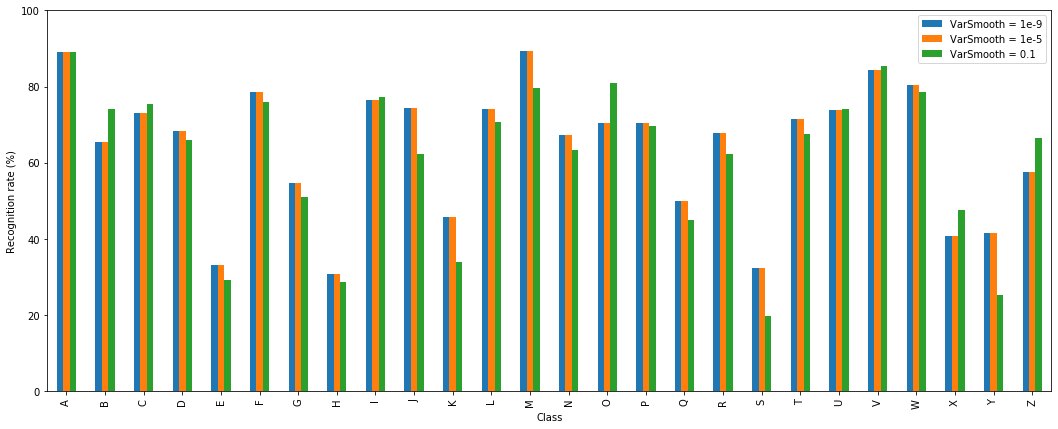

In [17]:
n_plot = recognition_compare_graph(pred_table_n1, pred_table_n2, pred_table_n3)
n_plot;

<p>Seperti yang telah disinggung sebelumnya, <i>recognition rate</i> untuk semua kelas tidak seragam satu dengan yang lain. Dengan kata lain, ada huruf yang akurasinya cukup tinggi, seperti A dan V, dan ada juga yang sebaliknya yaitu akurasinya cukup rendah, seperti E, H, dan S. Kita tahu bahwa algoritma ini, dalam mempelajari dan memrediksi data dalam dataset, berjalan menurut beberapa asumsi, tepatnya tiga asumsi yang telah disinggung sebelumnya. Semakin data dalam suatu kelas mendekati ketiga asumsi tersebut untuk semakin banyak <i>feature</i> yang ada, semakin baik juga <i>recognition rate</i>-nya, dan sebaliknya. Dengan demikian, kita bisa mengatakan bahwa data untuk kelas-kelas dengan <i>recognition rate</i> tinggi lebih dekat dengan asumsi, sedangkan yang rendah lebih jauh. Spesifik kepada kelas-kelas dengan akurasi rendah, sangat dimungkinkan bahwa distribusi data dalam kelas tersebut kurang mendekati distribusi Gaussian sehingga asumsi pertama dalam daftar sedikit banyak tidak <i>applicable</i> dan/atau terdapat dependensi yang cukup signifikan antara nilai <i>feature</i>-<i>feature</i> untuk data dalam kelas yang membuat asumsi kedua sedikit banyak juga terganggu.</p>
<p>Selain itu, terlihat juga bahwa peningkatan <span style="font-family:'Courier New';">var_smoothing</span> dari $10^{-9}$ ke $10^{-5}$ dapat dikatakan tidak berpengaruh sama sekali terhadap recognition rate. Hal ini dapat didasari oleh perubahan (selisih, bukan rasio) "penghalus" tersebut yang dapat dikatakan cukup kecil, sehingga perubahan pada bentuk distribusi yang dihasilkan akan <i>negligible</i>, membuat seolah-olah tidak ada perubahan yang terjadi. Akan tetapi, ketika <span style="font-family:'Courier New';">var_smoothing</span> meningkat dari $10^{-5}$ ke $0.1$, terlihat bahwa terdapat perubahan yang cukup signifikan pada <i>recongition rate</i> untuk sebagian besar kelas, ditandai dengan kenaikan atau penurunan <i>recognition rate</i> dibandingkan dengan dua variasi hyperparameter sebelumnya. Kenyataan ini dapat dikaitkan dengan kenaikan parameter variasi yang cukup besar, yaitu hampir mendekati 10% dari kelas-<i>feature</i> dengan variasi terbesar. Meningkatnya parameter variasi untuk setiap kelas untuk setiap <i>feature</i> untuk setiap variasi hyperparameter tentu akan mengubah bentuk distribusi Gaussian tersebut (perubahan bentuk ini akan dijelaskan setelah ini), yang secara tidak langsung akan mengubah kecocokan distribusi terhadap dataset per kelas per <i>feature</i>. Nilai <i>recognition rate</i> yang meningkat, menurun, dan tetap dibandingkan <i>recognition rate</i> hyperparameter sebelumnya mengindikasikan bahwa setelah variasi ditingkatkan, distribusi Gaussian yang dihasilkan menjadi semakin cocok, semakin tidak cocok, dan tetap terhadap dataset kelas-kelas yang terkait. Tidak ada pola khusus terkait peningkatan, penurunan, atau tetapnya nilai pada kelas-kelas ini: semua bergantung pada distribusi dan pemenuhan pada ketiga asumsi oleh dataset.</p>
<p>Terakhir, kita dapat melakukan analisis pada jalannya algoritma dengan memvisualisasikan distribusi Gaussian dari setiap feature, setiap class, dan setiap variasi hyperparameter. Untuk memudahkan visualisasi tanpa menghilangkan esensi distribusinya, kita hanya akan menggambarkan distribusi Gaussian untuk sembilan feature pertama sesuai urutan pada dataset (dari "x-box" sampai "y2bar") untuk salah satu kelas saja (dalam hal ini, saya memilih kelas huruf "J") dan untuk semua variasi hyperparameter (dengan maksud memvisualisasikan pengaruh <i>variance smoothing</i> terhadap distribusi yang dihasilkan). Untuk melakukannya, kita dapat memanggil <span style="font-family:'Courier New'">gaussian_plot_j()</span> yang telah kita buat sebelumnya, yang akan mengembalikan sebuah grafik yang terdiri dari sembilan subplot, dimana di dalam masing-masing subplot tersebut akan digambarkan distribusi Gaussian salah satu dari kesembilan <i>feature</i> yang dipertimbangkan, dengan hanya mengacu pada data dari kelas "J" saja, untuk ketiga variasi hyperparameter. Setelah fungsi mengembalikan grafik tersebut, grafik kemudian ditampilkan.</p>

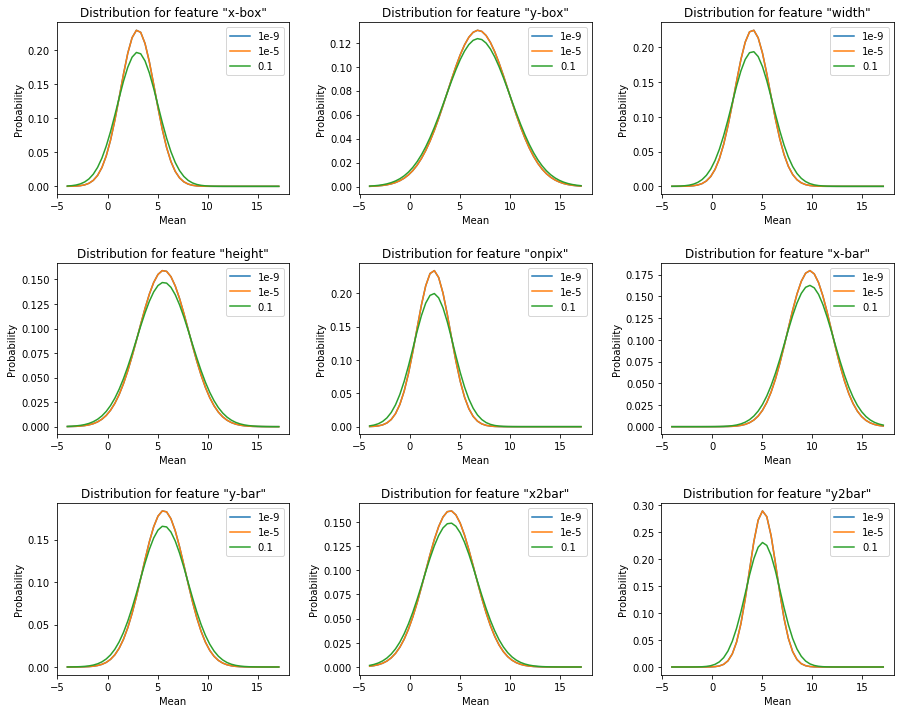

In [18]:
plt_n = gaussian_plot_j(var_n1, var_n2, var_n3, mean_n1, mean_n2, mean_n3)
plt_n.show()

<p>Dari semua grafik di atas, kita dapat mengatakan bahwa perubahan <i>variance smoothing</i> dari $10^{-9}$ ke $10^{-5}$ terlihat sama sekali tidak mengubah distribusi Gaussian, ditunjukkan dengan grafik distribusi untuk $10^{-9}$ (biru) dan $10^{-5}$ (jingga) yang berimpitan, berlaku untuk semua subplot yang berarti berlaku untuk kesembilan <i>feature</i> tersebut. Ini disebabkan peningkatan <i>variance smoothing</i> kecil secara jumlah, sehingga peningkatan variasi dan standar deviasi semua distribusi juga negligible. Karena distribusi hampir tidak berubah bentuk, <i>likelihood</i> juga negligible sehingga <i>recognition rate</i> juga negligible, membuat seolah-olah tidak ada perubahan yang terjadi padanya seperti yang ditunjukkan pada grafik batang sebelumnya. Akan tetapi, distribusi yang berbeda terlihat jelas pada grafik hijau untuk semua subplot, yang menyatakan distribusi setelah ditambah <i>variance smoothing</i> = $0.1$. Distribusi dengan <i>variance smoothing</i> ini terlihat sedikit lebih pendek tetapi lebih lebar dibandingkan teman-temannya, yang wajar terjadi jika <i>mean</i> dibuat tetap sedangkan standar deviasi diperbesar. Peningkatan standar deviasi ini diinisiasi oleh peningkatan variasi akibat penambahan <i>variance smoothing</i> yang cukup besar secara jumlah. Perubahan bentuk distribusi ini tentu membuat <i>likelihood</i> berubah, yang secara tidak langsung akan berpengaruh terhadap <i>recognition rate</i> (ada yang meningkat, menurun, dan tetap, lagi-lagi tergantung pada kecocokan setiap feature setiap kelas terhadap distribusi, seperti yang sempat disinggung sebelumnya).</p>
<p>Di samping itu, terlihat bahwa <i>mean</i> (ditunjukkan dengan titik balik) dan standar deviasi (ditunjukkan oleh kecuraman distribusi) untuk semua <i>feature</i>-kelas sangat dipengaruhi oleh distribusi data dalam masing-masing <i>feature</i>-kelas tersebut, dimana <i>mean</i> menyatakan "rata-rata" nilai dan standar deviasi menyatakan akar variasi data. <i>Mean</i> ini sebanding nilai-nilai data secara umum, sedangkan semakin variatif data, semakin tinggi juga standar deviasinya, yang berakibat pada semakin landainya kurva distribusi. Sebagai contoh, kita tahu bahwa nilai-nilai pada feature "x-box" untuk kelas "J" berkisar antara 1 hingga 5 sehingga <i>mean</i>-nya tidak akan jauh-jauh dari nilai tengah antara keduanya, terlihat sebagai titik balik kurva-kurva dalam subplot pertama. Contoh lain terkait dengan feature "y-bar" yang memiliki nilai-nilai yang cukup tinggi pada dataset untuk kelas "J", sehingga <i>mean</i>-nya pun juga relatif tinggi. Sementara itu, di antara kesembilan <i>feature</i> yang dipertimbangkan, terlihat secara sekilas bahwa "y-box" memiliki kurva yang paling landai sedangkan "y2-bar" adalah yang paling curam. Dari kenyataan ini, kita dapat menyatakan bahwa "y-box" cukup variatif sehingga standar deviasinya tinggi, sedangkan "y2bar" kurang variatif sehingga standar deviasinya rendah, semuanya berlaku terhadap kelas "J".</p>

<h2>Pertukaran data training dan testing</h2>
<p>Langkah selanjutnya adalah menukar data training dengan data testing, untuk melihat apakah penukaran keduanya membuat <i>recognition rate</i> menjadi lebih baik. Pertukaran ini dilakukan dengan menukarkan baik variabel independen (X) maupun variabel kontrol (Y) dari keduanya, dengan bantuan variabel <i>dummy</i> <span style="font-family:'Courier New">temp</span> melalui algoritma pertukaran biasa. Setelah keduanya ditukar dan kedua dataset yang telah ditukar tersebut dilabeli dengan label yang sesuai, cuplikan data dari keduanya akan ditampilkan.</p>

In [19]:
temp = X_train
X_train = X_test
X_test = temp

temp = Y_train
Y_train = Y_test
Y_test = temp

X_train_disp = caption(X_train.head(), "Features for training (after swapped, snapshot)")
Y_train_disp = caption(Y_train.to_frame().head(), "Features for training (after swapped, snapshot)")
X_test_disp = caption(X_test.head(), "Features for training (after swapped, snapshot)")
Y_test_disp = caption(Y_test.to_frame().head(), "Features for training (after swapped, snapshot)")

display(X_train_disp, Y_train_disp, X_test_disp, Y_test_disp)

,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,2,7,4,5,2,7,13,0,5,7,10,8,0,8,0,8
1,3,3,4,2,1,5,11,3,7,11,9,4,1,10,2,5
2,0,0,1,0,0,7,13,1,4,7,10,8,0,8,0,8
3,4,5,5,7,2,5,15,1,6,9,11,7,0,8,0,8
4,3,5,4,3,2,5,12,3,7,11,9,5,1,11,2,5


,letter
0,T
1,T
2,T
3,T
4,T


,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,4,8,5,6,3,7,12,3,7,7,11,8,2,12,1,7
1,3,6,4,4,3,6,12,4,6,8,11,8,2,12,1,8
2,1,0,2,0,0,7,15,2,4,7,10,8,0,8,0,8
3,5,7,7,6,6,5,8,3,8,7,7,9,3,7,7,5
4,2,7,3,4,1,5,14,1,6,9,11,7,0,8,0,8


,letter
0,T
1,T
2,T
3,T
4,T


<h3>Gaussian Naive Bayes terhadap dataset yang sudah ditukar</h3>
<p>Setelah pertukaran selesai dilakukan, kita dapat menjalankan urutan proses Gaussian Naive Bayes seperti yang telah dilakukan terhadap dataset asli. Seperti biasa, ketiga variasi <i>variance smoothing</i> akan dicoba di sini, yaitu $10^{-9}$, $10^{-5}$, dan $0.1$ secara berturut-turut. Baik dataset training maupun training beserta dengan nilai <i>variance smoothing</i> akan diteruskan kepada <span style="font-family:'Courier New'">gaussian_nb()</span> yang akan mengembalikan tabel prediksi secara sebelah menyebelah beserta seluruh parameter yang diatur dan diestimasi. Tabel ini kemudian akan menjadi <i>input</i> <span style="font-family:'Courier New'">pred_table()</span> yang akan mengembalikan tabel recognition rate.</p>

In [20]:
res_s1, classes, priors_s1, epsilon_s1, mean_s1, var_s1 = gaussian_nb(X_train, X_test, Y_train, Y_test, 1e-9)
res_s1_disp = caption(res_s1.head(), "Prediction result with variance smoothing 1e-9")
res_s1_disp

,Prediction,Expected,Correct?
0,T,T,Correct
1,T,T,Correct
2,T,T,Correct
3,K,T,Incorrect
4,T,T,Correct


In [21]:
pred_table_s1 = pred_table(res_s1)
pred_table_s1_disp = caption(pred_table_s1, "Recognition rate for every class with variance smoothing 1e-9")
pred_table_s1_disp

,Class,Correct,Total,Recognition rate (%)
0,A,345,407,84.77
1,B,292,407,71.74
2,C,310,407,76.17
3,D,288,407,70.76
4,E,160,407,39.31
5,F,282,407,69.29
6,G,216,407,53.07
7,H,127,407,31.2
8,I,315,407,77.4
9,J,285,407,70.02


In [22]:
res_s2, classes, priors_s2, epsilon_s2, mean_s2, var_s2 = gaussian_nb(X_train, X_test, Y_train, Y_test, 1e-5)
res_s2_disp = caption(res_s2.head(), "Prediction result with variance smoothing 1e-5")
res_s2_disp

,Prediction,Expected,Correct?
0,T,T,Correct
1,T,T,Correct
2,T,T,Correct
3,K,T,Incorrect
4,T,T,Correct


In [23]:
pred_table_s2 = pred_table(res_s2)
pred_table_s2_disp = caption(pred_table_s2, "Recognition rate for every class with variance smoothing 1e-5")
pred_table_s2_disp

,Class,Correct,Total,Recognition rate (%)
0,A,345,407,84.77
1,B,292,407,71.74
2,C,310,407,76.17
3,D,288,407,70.76
4,E,160,407,39.31
5,F,282,407,69.29
6,G,216,407,53.07
7,H,127,407,31.2
8,I,315,407,77.4
9,J,285,407,70.02


In [24]:
res_s3, classes, priors_s3, epsilon_s3, mean_s3, var_s3 = gaussian_nb(X_train, X_test, Y_train, Y_test, 0.1)
res_s3_disp = caption(res_s3.head(), "Prediction result with variance smoothing 0.1")
res_s3_disp

,Prediction,Expected,Correct?
0,T,T,Correct
1,T,T,Correct
2,T,T,Correct
3,X,T,Incorrect
4,T,T,Correct


In [25]:
pred_table_s3 = pred_table(res_s3)
pred_table_s3_disp = caption(pred_table_s3, "Recognition rate for every class with variance smoothing 0.1")
pred_table_s3_disp

,Class,Correct,Total,Recognition rate (%)
0,A,347,407,85.26
1,B,324,407,79.61
2,C,312,407,76.66
3,D,274,407,67.32
4,E,129,407,31.7
5,F,280,407,68.8
6,G,212,407,52.09
7,H,114,407,28.01
8,I,316,407,77.64
9,J,258,407,63.39


<h3>Analisis</h3>
<p>Seperti yang telah kita lakukan terhadap hasil eksekusi algoritma dengan dataset asli (tidak dibalik), kita juga akan menganalisis eksekusi algoritma dengan dataset yang telah dibalik ini dari sisi-sisi analisis yang sama seperti dengan dataset asli, salah satunya dengan tujuan membandingkan manakah di antara eksekusi dengan dataset asli dan yang telah dibalik yang menghasilkan recognition rate yang lebih baik. Seperti biasa, di dalam mempelajari dataset training dan memrediksi dataset testing, algoritma akan menyesuaikan <i>prior probability</i> untuk setiap kelasnya berdasarkan proporsi masing-masing kelas tersebut dalam dataset. Kita tahu bahwa <i>prior probability</i> adalah salah satu keluaran dari <span style="font-family:'Courier New'">gaussian_nb()</span>, sehingga kita dapat memanfaatkan ini lalu menampilkan hasilnya. Terlihat, bahwa lagi-lagi <i>prior probability</i> untuk setiap kelas sama untuk ketiga variasi <i>variance smoothing</i>, diakibatkan oleh kesamaan jumlah data setiap kelas.</p>

In [26]:
priors_s = pd.DataFrame(list(zip(classes, priors_s1, priors_s2, priors_s3)), columns=["Alphabet", "1e-9", "1e-5", "0.1"])
priors_s_disp = caption(priors_s, "Priori probabilities for each class for each hyperparameter variation")
priors_s_disp

,Alphabet,1e-9,1e-5,0.1
0,A,0.0384615,0.0384615,0.0384615
1,B,0.0384615,0.0384615,0.0384615
2,C,0.0384615,0.0384615,0.0384615
3,D,0.0384615,0.0384615,0.0384615
4,E,0.0384615,0.0384615,0.0384615
5,F,0.0384615,0.0384615,0.0384615
6,G,0.0384615,0.0384615,0.0384615
7,H,0.0384615,0.0384615,0.0384615
8,I,0.0384615,0.0384615,0.0384615
9,J,0.0384615,0.0384615,0.0384615


<p>Selanjutnya, kita akan mencoba untuk menampilkan nilai variasi absolut yang ditambahkan pada semua variasi <i>feature</i>-kelas dalam dataset untuk masing-masing variasi <i>variance smoothing</i>, juga dengan memanfaatkan keluaran <span style="font-family:'Courier New'">gaussian_nb()</span> berupa <span style="font-family:'Courier New'">epsilon</span> untuk ketiga variasi tersebut, lalu menampilkan semuanya. Berdasarkan ketiga nilai absolut aditif untuk ketiga variasi <i>variance smoothing</i> yang ditampilkan, didapatkan bahwa dengan nilai aditif yang ditambahkan sebanding dengan <i>variance smoothing</i>, dimana hubungan ini sama dengan yang didapatkan pada dataset tidak dibalik. Hanya saja, nilai aditifnya sedikit berbeda dibandingkan nilai aditif dengan dataset tidak dibalik, berhubung variasi tertingginya pun juga berubah.</p>

In [27]:
print("(Absolute) additive value for each variance for var_smoothing = 1e-9: " + str(epsilon_s1) + "\n" +
      "(Absolute) additive value for each variance for var_smoothing = 1e-5: " + str(epsilon_s2) + "\n" +
      "(Absolute) additive value for each variance for var_smoothing = 0.1: " + str(epsilon_s3) + "\n")

(Absolute) additive value for each variance for var_smoothing = 1e-9: 1.1038419485830185e-08
(Absolute) additive value for each variance for var_smoothing = 1e-5: 0.00011038419485830185
(Absolute) additive value for each variance for var_smoothing = 0.1: 1.1038419485830184



<p>Selanjutnya, kita akan membandingkan <i>recognition rate</i> dari ketiga variasi <i>variance smoothing</i> untuk setiap kelas yang mungkin dalam dataset yang telah ditukar. Grafik perbandingan ini bisa kita dapatkan dengan memanggil <span style="font-family:'Courier New'">recognition_compare_graph()</span> dengan meneruskan ketiga <i>prediction table</i> dari hasil pengenalan pada ketiga variasi hyperparameter sebagai parameternya. Setelah grafik didapatkan, grafik kemudian ditampilkan. Terlihat dari grafik tersebut bahwa jumlah kelas dengan <i>recognition rate</i> rendah (di bawah 40%) sedikit lebih banyak yaitu meliputi empat kelas ("E", "H", "S", dan "Y"), dibandingkan dengan jumlah kelas dengan <i>recognition rate</i> rendah dengan dataset tidak dibalik, yaitu hanya sebanyak tiga kelas yaitu ("E", "H", dan "S", untuk "Y" masih di sedikit di atas 40%). Seperti yang telah disinggung pada penjelasan perbandingan <i>recognition rate</i> dengan dataset asli, kelas-kelas yang tidak berhasil dikenali dengan baik (yaitu yang <i>recognition rate</i>-nya rendah) memiliki data yang kurang sesuai dengan asumsi Naive Bayes, sedangkan sebaliknya, yang berhasil dikenali dengan baik (<i>recognition rate</i> tinggi) memiliki data yang cukup mendekati asumsi. Jumlah kelas yang <i>recognition rate</i>-nya meningkat dan menurun akibat penukaran dataset hampir sama, dengan tingkat peningkatan dan penurunan rata-rata yang cenderung sedikit. Kenyataan ini terjadi sebagai akibat dari sifat dataset training yang relatif sama dengan dataset testing sebagai akibat dari baiknya pengacakan terhadap dataset, sehingga keduanya dapat dikatakan merepresentasikan keseluruhan dataset secara sama dan pertukaran keduanya tidak terlalu berpengaruh terhadap proses pembelajaran dan prediksi beserta dengan parameter-parameter yang dihasilkan dan diprediksi oleh algoritma. Mempertimbangkan aspek bahwa resultan perubahan <i>recognition rate</i> mendekati nol ketika kedua dataset ditukar, dapat dikatakan bahwa hasil algoritma untuk kedua variasi dataset ini sama baiknya. Akan tetapi, jika mempertimbangkan jumlah kelas dengan <i>recognition rate</i> rendah, maka kita tahu bahwa jumlah ini lebih rendah untuk dataset asli dibandingkan yang telah ditukar, sehingga secara keseluruhan, hasil algoritma dengan dataset aslilah yang lebih baik.</p>
<p>Selanjutnya, seperti dengan dataset yang tidak ditukar, terlihat bahwa peningkatan <i>variance smoothing</i> dari $10^{-9}$ ke $10^{-5}$ ("tahap peningkatan pertama") dapat dikatakan tidak berpengaruh sama sekali terhadap <i>recognition rate</i> semua kelas (tetap sama antara kedua variasi tersebut), tetapi ketika ditingkatkan ke $0.1$ ("tahap peningkatan kedua"), pengaruh yang ditimbulkan signifikan yaitu untuk semua kelas, beberapa meningkat dan sisanya mengalami penurunan. Kedua tahapan peningkatan di atas hampir tidak berpengaruh dan cukup berpengaruh secara berturut-turut, karena peningkatan variasi secara jumlah pada tahap peningkatan kedua jauh lebih besar dibandingkan tahap peningkatan pertama. Spesifik terhadap tahapan peningkatan kedua, penambahan variasi pada semua variasi tentu menyebabkan peningkatan pada standar deviasi, yang akan berpengaruh terhadap distribusi setiap <i>feature</i>-kelas tersebut sehingga likelihood pun juga berubah. Pengaruh perubahan likelihood ini akan merembet pada kecocokan data setiap <i>feature</i>-kelas terhadap distribusi juga <i>recognition rate</i> setiap kelas: jika meningkat maka semakin cocok untuk keseluruhan <i>feature</i>, sebaliknya semakin tidak cocok.</p>

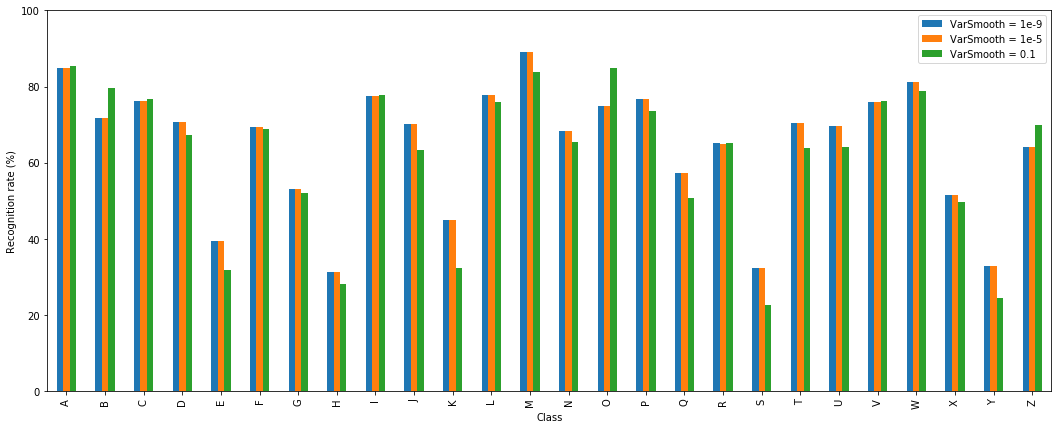

In [28]:
s_plot = recognition_compare_graph(pred_table_s1, pred_table_s2, pred_table_s3)
s_plot;

<p>Analisis terakhir terhadap hasil algoritma dengan dataset yang ditukar ini adalah terkait dengan distribusi Gaussian untuk setiap <i>feature</i>-kelas dalam dataset. Seperti yang dilakukan pada analisis serupa dengan dataset asli, analisis distribusi yang dilakukan di sini juga akan terbatas pada sembilan parameter pertama dalam dataset untuk kelas "J". Grafik mendasari analisis dapat dibuat dengan memanggil <span style="font-family:'Courier New'">gaussian_plot_j()</span> dengan mensuplaikan semua nilai <i>mean</i> dan <i>variance</i> dari ketiga variasi hyperparameter sebagai argumennya. Grafik ini terdiri dari sembilan subplot dimana setiap subplot menyatakan distribusi setiap <i>feature</i> untuk ketiga variasi hyperparameter. Grafik yang dikembalikan ini kemudian akan ditampilkan. Sekilas, pola distribusi untuk kesembilan subplot mirip dengan pola distribusi dengan dataset asli. Terlihat juga bahwa distribusi untuk <i>smoothing variance</i> = $10^{-9}$ dan $10^{-5}$ bertindihan satu sama lain, dikarenakan perubahan variasi dari $10^{-9}$ ke $10^{-5}$ <i>negligible</i> akibat jumlah variasi yang ditambahkan tidak signifikan, berlaku untuk semua subplot. Meskipun begitu, grafik distribusi untuk <i>smoothing variance</i> = $0.1$ (hijau) terlihat "lain sendiri" dibandingkan distribusi kedua hyperparameter lainnya, yaitu lebih lebar tetapi lebih pendek. Perubahan ukuran seperti ini wajar, karena penambahan variasi cukup signifikan sedangkan <i>mean</i> dibuat tetap. Di samping itu, <i>mean</i> untuk setiap subplot merpresentasikan "nilai tengah" data <i>feature</i> tersebut untuk kelas "J" dan standar deviasi merepresentasikan <i>swing</i> data tersebut, yang sedikit banyak sudah dipaparkan pada analisis serupa dengan dataset asli.</p>

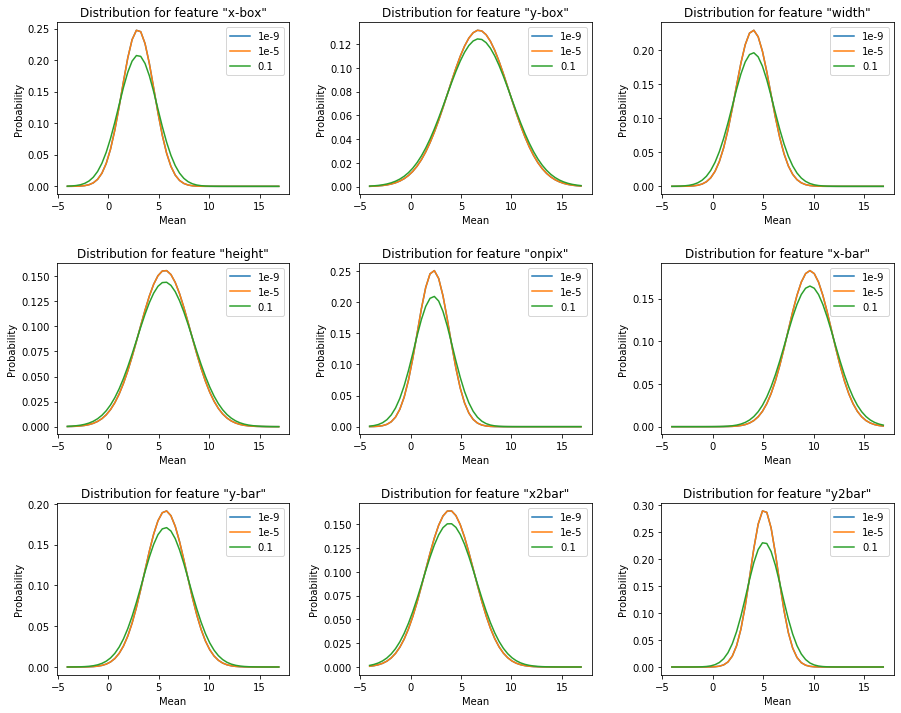

In [29]:
plt_s = gaussian_plot_j(var_s1, var_s2, var_s3, mean_s1, mean_s2, mean_s3)
plt_s.show()

<h2>Penyimpanan tabel-tabel <i>recognition rate</i> ke dalam Excel</h2>
<p>Keenam tabel <i>recognition rate</i>, satu untuk setiap variasi dataset untuk setiap variasi hyperparameter, sebagai hasil eksekusi algoritma untuk setiap variasi tersebut, akan disimpan ke dalam sebuah <i>file</i> Microsoft Excel (<span style="font-family:'Courier-New'">.xlsx</span>), dimana setiap tabel akan disimpan ke dalam lembarnya masing-masing dalam <i>file</i> tersebut. Nantinya, semua lembar dari algoritma Naive Bayes ini akan disandingkan dengan lembar-lembar hasil algoritma penglasifikasi lainnya juga untuk setiap variasi di sana, yang didapatkan dari anggota kelompok lainnya.</p>

In [30]:
with pd.ExcelWriter('Export.xlsx') as writer:
    pred_table_n1.to_excel(writer, sheet_name='Naive Bayes - Normal 1e-9', index=False, freeze_panes=[1, 0])
    pred_table_n2.to_excel(writer, sheet_name='Naive Bayes - Normal 1e-5', index=False, freeze_panes=[1, 0])
    pred_table_n3.to_excel(writer, sheet_name='Naive Bayes - Normal 0.1', index=False, freeze_panes=[1, 0])
    pred_table_s1.to_excel(writer, sheet_name='Naive Bayes - Swapped 1e-9', index=False, freeze_panes=[1, 0])
    pred_table_s2.to_excel(writer, sheet_name='Naive Bayes - Swapped 1e-5', index=False, freeze_panes=[1, 0])
    pred_table_s3.to_excel(writer, sheet_name='Naive Bayes - Swapped 0.1', index=False, freeze_panes=[1, 0])